<h2>Getting X-ray Data</h2>

In [2]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
os.environ['KAGGLE_USERNAME'] = 'jxckson'
os.environ['KAGGLE_KEY'] = 'ad52c2a2f98b0640f6bcd914e2550a56'

In [ ]:
!kaggle datasets download --force -d paultimothymooney/chest-xray-pneumonia

In [ ]:
!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

<h2>Checking out the data</h2>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras

Using TensorFlow backend.
/home/jack/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jack/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jack/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jack/.local/lib/python3.6/site-packages/tensorflow/python/framewo

In [3]:
training_dir = './chest_xray/train'
validation_dir = './chest_xray/test'
test_dir = './chest_xray/val'

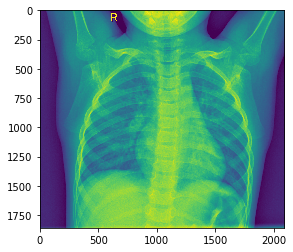

In [4]:
img = mpimg.imread(training_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [5]:
def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)

      amount += 1

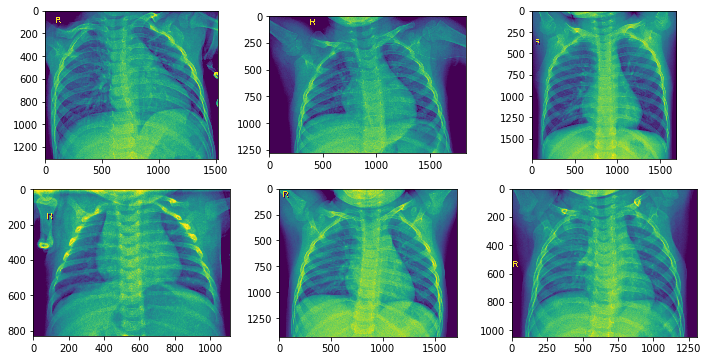

In [6]:
plot_images(training_dir + '/NORMAL')

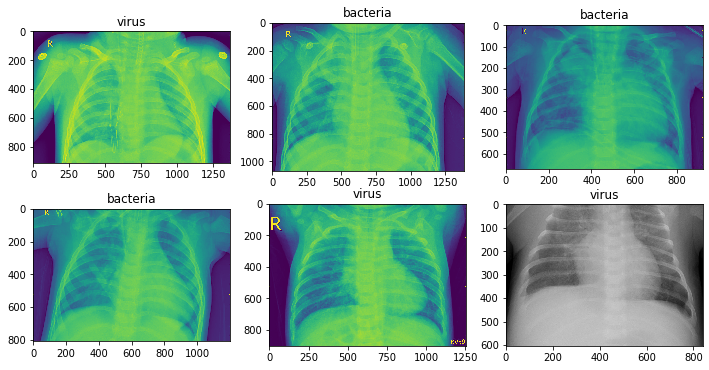

In [7]:
plot_images(training_dir + '/PNEUMONIA', labeled=True)

<h2>Training the model</h2>

In [8]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [19]:
def get_model():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(2, activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)
  print(predictions)

  for layer in base_model.layers:
    layer.trainable = False
  
  model.summary()
  return model

In [20]:
model = get_model()

Tensor("dense_4/Softmax:0", shape=(?, 2), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_96[0][0]     
____________________________________________________

In [11]:
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
163/163 [==============================] - 259s 2s/step - loss: 0.3972 - acc: 0.8614 - val_loss: 1.4539 - val_acc: 0.7228
Epoch 2/5
163/163 [==============================] - 252s 2s/step - loss: 0.2506 - acc: 0.8993 - val_loss: 1.6718 - val_acc: 0.7179
Epoch 3/5
163/163 [==============================] - 266s 2s/step - loss: 0.2662 - acc: 0.8940 - val_loss: 1.3270 - val_acc: 0.7212
Epoch 4/5
163/163 [==============================] - 241s 1s/step - loss: 0.2619 - acc: 0.8961 - val_loss: 1.2872 - val_acc: 0.6939
Epoch 5/5
163/163 [==============================] - 267s 2s/step - loss: 0.2488 - acc: 0.8967 - val_loss: 1.1307 - val_acc: 0.6875


<h2>Evaluate the model</h2>

In [17]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])
print(result[2:5])

16/16 [==============================] - 1s 52ms/step
Loss: 0.8688178217153109
Accuracy: 0.75
[]


In [18]:
print(predictions)

NameError: name 'predictions' is not defined

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets.samples_generator import make_blobs
# generate 2d classification dataset
X, y = X_train
# fit final model
model = LogisticRegression()
model.fit(X, y)
# new instances where we do not know the answer
Xnew, _ = make_blobs(n_samples=3, centers=2, n_features=2, random_state=1)
# make a prediction
ynew = model.predict(Xnew)
# show the inputs and predicted outputs
for i in range(len(Xnew)):
	print("X=%s, Predicted=%s" % (Xnew[i], ynew[i]))

X=[-0.79415228  2.10495117], Predicted=0
X=[-8.25290074 -4.71455545], Predicted=1
X=[-2.18773166  3.33352125], Predicted=0


/home/jack/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [22]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

NameError: name 'X_test' is not defined